In [256]:
import numpy as np
import torch
from torch import nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd

In [49]:
%config InlineBackend.figure_format = 'retina'
sns.set()

# Normal distribution

## Maximum likelihood

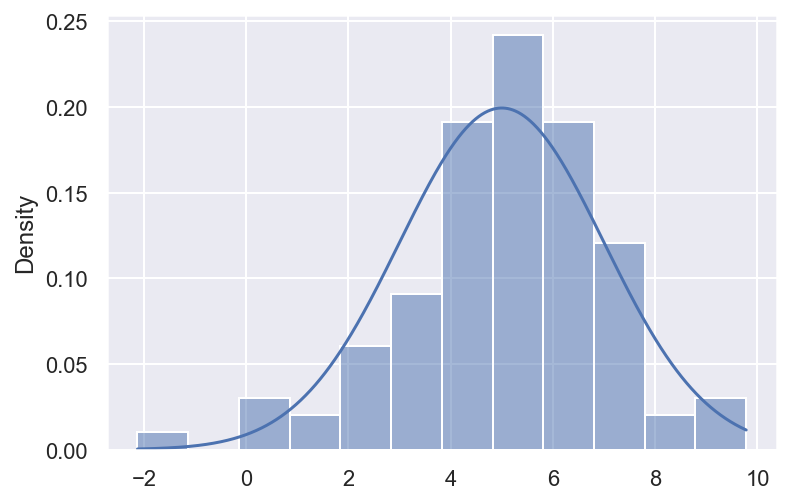

In [145]:
mu = 5
sigma = 2
N = 1000
np.random.seed(1234)

x_dist = scipy.stats.norm(loc=mu, scale=sigma)

x = x_dist.rvs(size=100)
x_pdf = np.linspace(np.min(x), np.max(x), N)
pdf = x_dist.pdf(x_pdf)

fig, ax = plt.subplots()
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
ax.plot(x_pdf, pdf);

In [146]:
class Gaussian(nn.Module):
    
    def __init__(self, x):
        super().__init__()
        self.X = torch.tensor(x[:, None], dtype=torch.float)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
    
    def log_lik(self):
        mu = self.alpha
        sg = self.beta.exp()
        likelihood = dist.Normal(mu, sg).log_prob(self.X)
        return likelihood.sum()
    
    def loss(self):
        return -self.log_lik() 

In [147]:
model = Gaussian(x)
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [148]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    loss = model.loss()
    loss.backward()
    optim.step()

In [149]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([5.0702], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.6888], grad_fn=<SliceBackward>) 



In [150]:
np.exp(0.6888)

1.9913245095043566

## VI

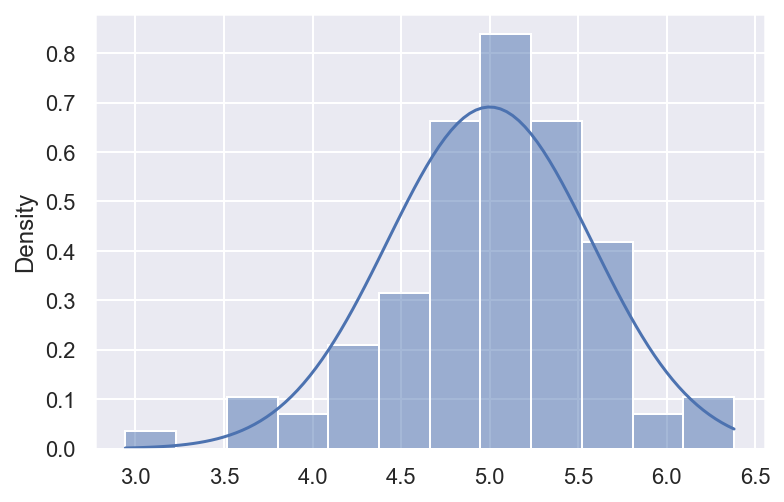

In [220]:
mu = 5
precision = 3
N = 100
np.random.seed(1234)

x_dist = scipy.stats.norm(loc=mu, scale=np.sqrt(1/precision))

x = x_dist.rvs(size=N)
x_pdf = np.linspace(np.min(x), np.max(x), 100)
pdf = x_dist.pdf(x_pdf)

fig, ax = plt.subplots()
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
ax.plot(x_pdf, pdf);

$$ {\begin{aligned}\tau &\sim \operatorname {Gamma} (a_{0},b_{0})\\\mu &\sim {\mathcal {N}}(\mu _{0},(\lambda _{0}\tau )^{-1})\\\{x_{1},\dots ,x_{N}\}&\sim {\mathcal {N}}(\mu ,\tau ^{-1})\\N&={\text{number of data points}}\end{aligned}}$$

$$ {\begin{aligned}q_{\mu }^{*}(\mu )&\sim {\mathcal {N}}(\mu \mid \mu _{N},\lambda _{N}^{-1})\\\mu _{N}&={\frac {\lambda _{0}\mu _{0}+N{\bar {x}}}{\lambda _{0}+N}}\\\lambda _{N}&=(\lambda _{0}+N)\operatorname {E} _{\tau }[\tau ]\\{\bar {x}}&={\frac {1}{N}}\sum _{n=1}^{N}x_{n}\end{aligned}}$$

$$ {\begin{aligned}q_{\tau }^{*}(\tau )&\sim \operatorname {Gamma}(\tau \mid a_{N},b_{N})\\a_{N}&=a_{0}+{\frac  {N+1}{2}}\\b_{N}&=b_{0}+{\frac  {1}{2}}\operatorname {E}_{\mu }\left[\sum _{{n=1}}^{N}(x_{n}-\mu )^{2}+\lambda _{0}(\mu -\mu _{0})^{2}\right]\end{aligned}}$$

In [234]:
lambda0 = 1
mu0 = 0
a0 = 1
b0 = 1

sum_x = x.sum()
sum_x2 = (x**2).sum()

mu_n = (lambda0*mu0 + sum_x) / (lambda0 + N)
a_n = a0 + (N+1)/2

lambda_n = 1
b_n = 1

i = 0
while True:
    
    b_brakets = (lambda0 + N)*(1/lambda_n + mu_n**2) \
        - 2*(lambda0*mu0+sum_x)*mu_n + sum_x2 + lambda0*mu0**2 
    new_b_n = b0 + 0.5*b_brakets

    diff_b_n = new_b_n - b_n
    b_n = new_b_n
    
    new_lambda_n = (lambda0 + N) * (a_n/b_n)
    
    diff_lambda_n = new_lambda_n - lambda_n
    lambda_n = new_lambda_n
        
    print(f"[step {i}] diff b_n = {np.abs(diff_b_n):.5f}")
    print(f"[step {i}] diff lambda_n = {np.abs(diff_lambda_n):.5f}")
    
    if np.abs(diff_lambda_n) < 1e-05 and np.abs(diff_b_n) < 1e-05:
        break
        
    i += 1

print(f'lambda_n', lambda_n)
print(f'b_n', b_n)

[step 0] diff b_n = 79.49994
[step 0] diff lambda_n = 63.61496
[step 1] diff b_n = 49.71845
[step 1] diff lambda_n = 104.36647
[step 2] diff b_n = 0.48270
[step 2] diff lambda_n = 2.69212
[step 3] diff b_n = 0.00469
[step 3] diff lambda_n = 0.02656
[step 4] diff b_n = 0.00005
[step 4] diff lambda_n = 0.00026
[step 5] diff b_n = 0.00000
[step 5] diff lambda_n = 0.00000
lambda_n 171.7003627413106
b_n 30.2940536464489


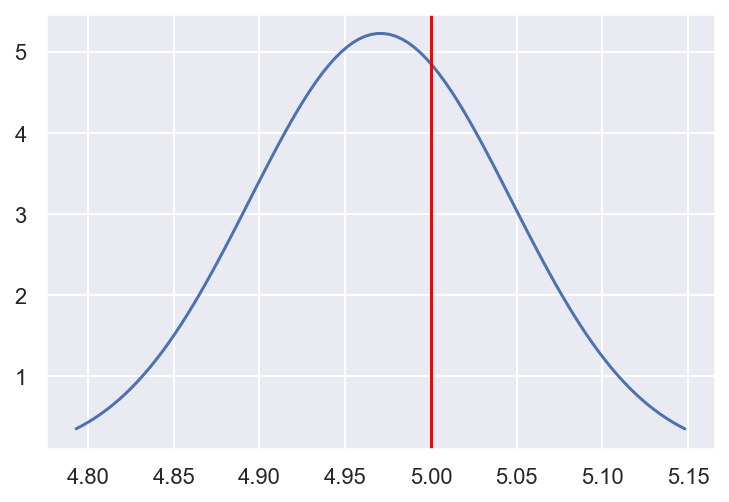

In [235]:
q_mu_dist = scipy.stats.norm(loc=mu_n, scale=np.sqrt(1/lambda_n))

x_plot = np.linspace(q_mu_dist.ppf(0.01), q_mu_dist.ppf(0.99), 100)
q_mu_pdf = q_mu_dist.pdf(x_plot)

fig, ax = plt.subplots()
ax.plot(x_plot, q_mu_pdf)
ax.axvline(mu, color='red');

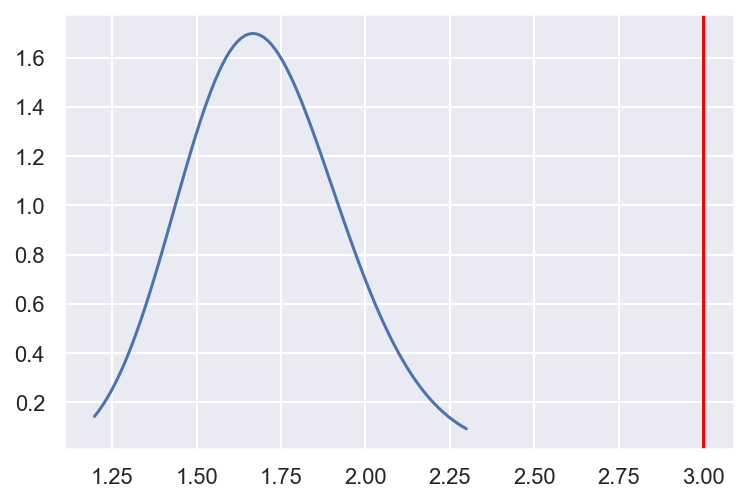

In [223]:
q_tau_dist = scipy.stats.gamma(a=a_n, scale=1/b_n)

x_plot = np.linspace(q_tau_dist.ppf(0.01), q_tau_dist.ppf(0.99), 100)
q_tau_pdf = q_tau_dist.pdf(x_plot)

fig, ax = plt.subplots()
ax.plot(x_plot, q_tau_pdf)
ax.axvline(precision, color='red');

In [224]:
mode_q_mu = mu_n
mode_q_tau = (a_n - 1)/b_n
print(mode_q_mu, mode_q_tau)

4.97056642189538 1.666993813022433


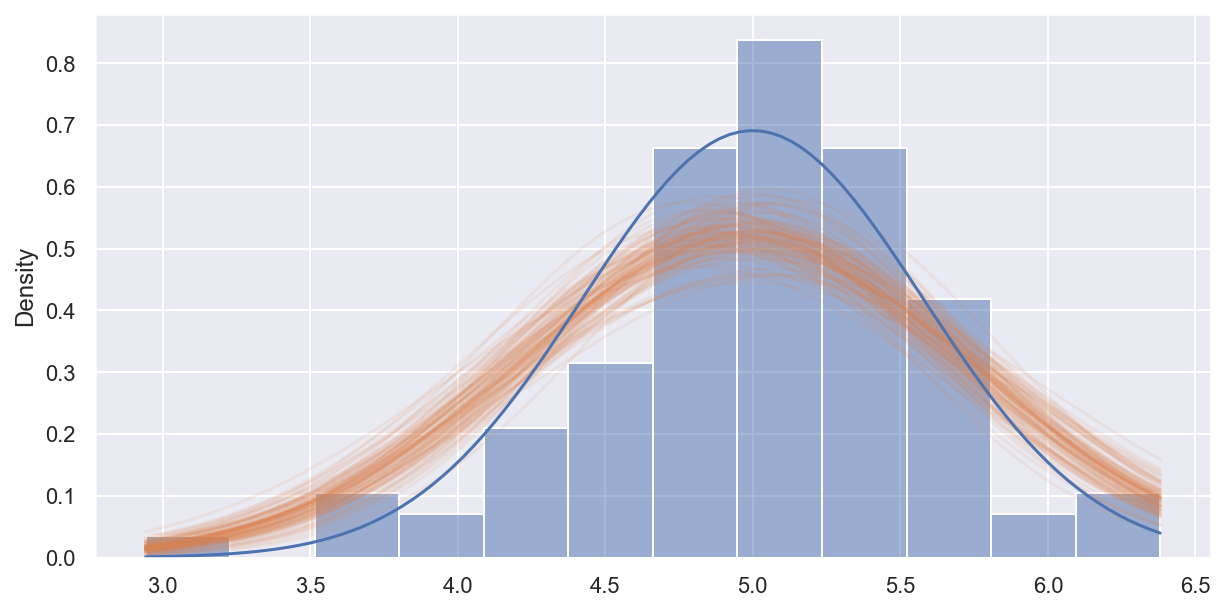

In [225]:
x_plot = np.linspace(np.min(x), np.max(x), 100)
x_pdf = x_dist.pdf(x_plot)

# est_x_pdf = scipy.stats.norm(loc=mode_q_mu, 
#                              scale=np.sqrt(1/mode_q_tau)).pdf(x_plot)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
# ax.plot(x_plot, est_x_pdf)

for i in range(100):
    sp_q_mu = q_mu_dist.rvs()
    sp_q_tau = q_tau_dist.rvs()
    est_x_pdf = scipy.stats.norm(
        loc=sp_q_mu, 
        scale=np.sqrt(1/sp_q_tau)).pdf(x_plot)
    ax.plot(x_plot, est_x_pdf, color='C1', alpha=0.1)
    
ax.plot(x_plot, x_pdf);

## Automatic VI using Numpyro (NOT WORKING)

In [226]:
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, TraceMeanField_ELBO, autoguide
from numpyro.optim import Adam
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions import constraints
from jax import random
import jax.numpy as jnp
import jax.scipy.special as jss
import scipy

In [250]:
def model():

    tau = npr.sample("tau", dist.Gamma(a0, b0))
    mu = npr.sample("mu",  dist.Normal(mu0, (1/(lambda0*tau))**0.5))
    with npr.plate("data", N):
        npr.sample("obs", dist.Normal(mu, (1/tau)**0.5), obs=y)

def guide():
    
    a_n = npr.param("a_n", 1.0, constraint=constraints.positive)
    b_n = npr.param("b_n", 1.0, constraint=constraints.positive)
            
    mu_n = npr.param("mu_n", 0.0)
    lambda_n = npr.param("lambda_n", 1.0, constraint=constraints.positive)
    
    npr.sample("tau", dist.Gamma(a_n, b_n))
    npr.sample("mu", dist.Normal(mu_n, (1/lambda_n)**0.5))

In [251]:
# set up the optimizer
optimizer = Adam(step_size=0.0005)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO())

svi_result = svi.run(random.PRNGKey(0), 100000)

100%|██████████| 100000/100000 [01:07<00:00, 1484.86it/s, init loss: 4100.8003, avg. loss [95001-100000]: 196.9726]


In [252]:
params = svi_result.params
params

{'a_n': DeviceArray(25.528908, dtype=float32),
 'b_n': DeviceArray(68.6, dtype=float32),
 'lambda_n': DeviceArray(37.644333, dtype=float32),
 'mu_n': DeviceArray(6.482311, dtype=float32)}

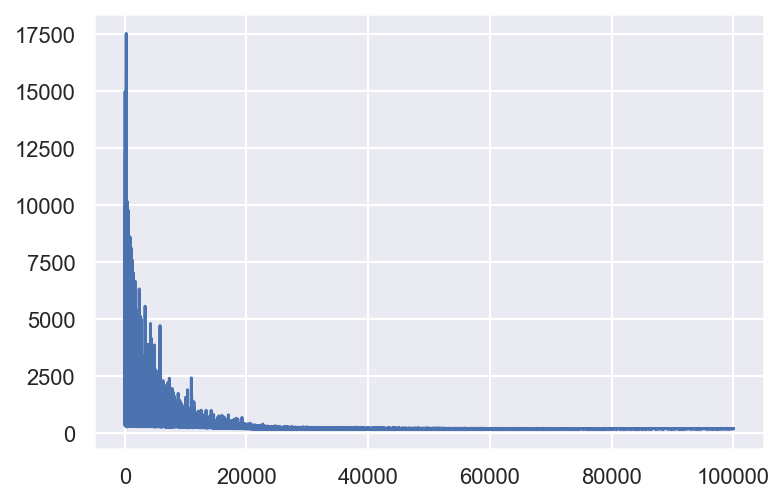

In [253]:
loss = svi_result.losses
plt.plot(loss)

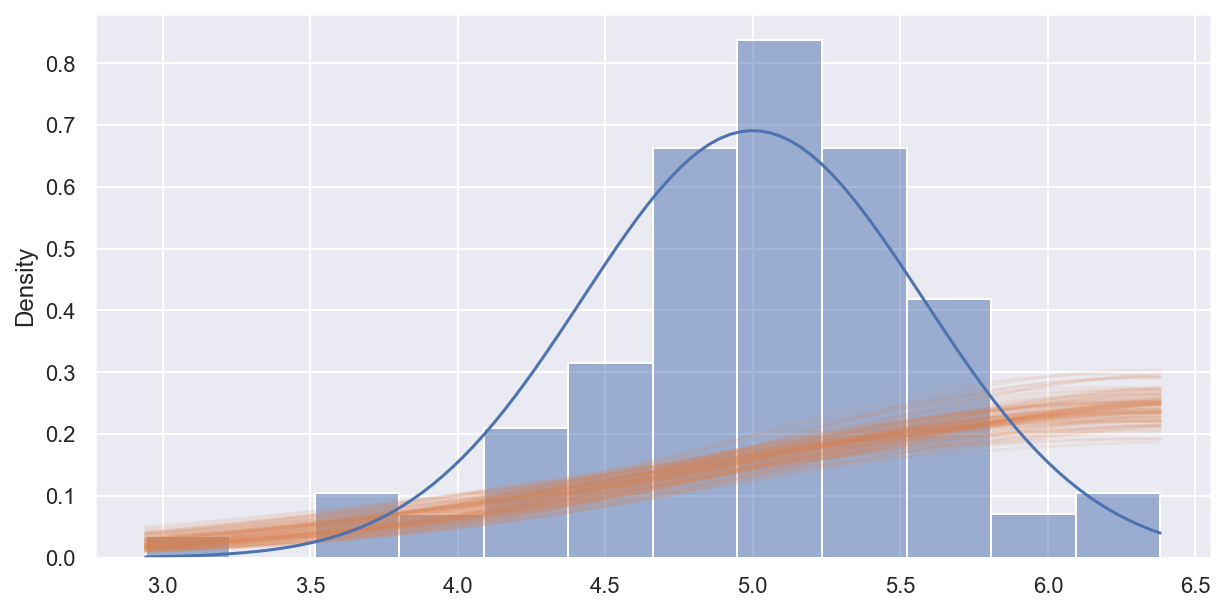

In [254]:
a_n = params['a_n'].item()
b_n = params['b_n'].item()
mu_n = params['mu_n'].item()
lambda_n = params['lambda_n'].item()

q_mu_dist = scipy.stats.norm(loc=mu_n, scale=(1/lambda_n)**0.5)
q_tau_dist = scipy.stats.gamma(a=a_n, scale=1/b_n)

x_plot = np.linspace(np.min(x), np.max(x), 100)
x_pdf = x_dist.pdf(x_plot)

# est_x_pdf = scipy.stats.norm(loc=mode_q_mu, 
#                              scale=np.sqrt(1/mode_q_tau)).pdf(x_plot)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x, bins='auto', stat='density', alpha=0.5)
# ax.plot(x_plot, est_x_pdf)

for i in range(100):
    sp_q_mu = q_mu_dist.rvs()
    sp_q_tau = q_tau_dist.rvs()
    est_x_pdf = scipy.stats.norm(
        loc=sp_q_mu, 
        scale=np.sqrt(1/sp_q_tau)).pdf(x_plot)
    ax.plot(x_plot, est_x_pdf, color='C1', alpha=0.1)
    
ax.plot(x_plot, x_pdf);

# Linear regression

## Make data

In [50]:
np.random.seed(123)

# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0 #1.0

# Generate and plot data
x = 10 * np.random.rand(100)
mu = alpha + beta * x
y = np.random.normal(mu, scale=sigma)

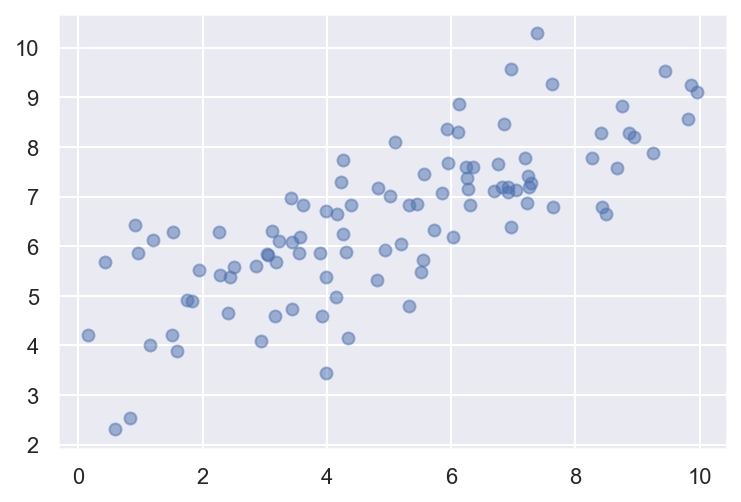

In [51]:
plt.scatter(x, y, alpha=0.5);

In [52]:
idx = np.argsort(x)
x = x[idx]
y = y[idx]
X = torch.tensor(x[:, None], dtype=torch.float)
Y = torch.tensor(y[:, None], dtype=torch.float)

## Least-square estimation (NOT modeling noise)

In [53]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
            
    def forward(self, x):
        y_pred = self.alpha + self.beta* x
        return y_pred

In [54]:
model = LinearRegression()
for name, param in model.named_parameters():
    print(
        f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [55]:
def det_loss(y_pred):
    return torch.square(y_pred - Y).sum()

In [56]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = model(X)
    loss = det_loss(y_pred)
    loss.backward()
    optim.step()

In [57]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([4.1693], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.4732], grad_fn=<SliceBackward>) 



## Maximum Likelihood Estimation (modeling Noise)

In [58]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))
        self.sigma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        y_pred = self.alpha + self.beta* x
        return y_pred
    
    def log_lik(self, x, y_pred):
        mu = self.alpha + self.beta*x
        sg = self.sigma.exp()
        likelihood = dist.Normal(mu, sg).log_prob(Y)
        return likelihood.sum()
    
    def loss(self, x, y_pred):
        return -self.log_lik(x, y_pred) 

In [59]:
model = LinearRegression()
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 

Layer: sigma | Size: torch.Size([1]) | Values : tensor([0.], grad_fn=<SliceBackward>) 



In [60]:
epochs = 5000

optim = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = model(X)
    loss = model.loss(X, y_pred)
    loss.backward()
    optim.step()

In [61]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: alpha | Size: torch.Size([1]) | Values : tensor([4.1699], grad_fn=<SliceBackward>) 

Layer: beta | Size: torch.Size([1]) | Values : tensor([0.4731], grad_fn=<SliceBackward>) 

Layer: sigma | Size: torch.Size([1]) | Values : tensor([-0.0219], grad_fn=<SliceBackward>) 



In [62]:
np.exp(-0.0219)

0.9783380639660794

## Variational inference

\begin{aligned}
y &\sim \mathcal{N}(\beta x, \sigma^2) \\[.5em]
\beta &\sim \mathcal{N}(0, \sigma^2 \tau^2) \\[.5em]
\sigma^2 &\propto \frac{1}{\sigma^2} \enspace ,
\end{aligned}

In [658]:
def compute_elbo(y, x, beta_mu, beta_sd, nu, tau2):
    n = len(y)
    sum_y2 = np.sum(y**2)
    sum_x2 = np.sum(x**2)
    sum_yx = np.sum(x*y)
    
    sigma2_shape = (n + 1)/2

    # Takes a function and computes its expectation with respect to q(\beta)
    def E_q_beta(fn):
        return scipy.integrate.quad_vec(
            lambda beta: scipy.stats.norm.pdf(loc=beta_mu, scale=beta_sd, x=beta) * fn(beta), 
            -np.inf, np.inf)[0]

    # Takes a function and computes its expectation with respect to q(\sigma^2)
    def E_q_sigma2(fn):
        return scipy.integrate.quad_vec(
            lambda sigma: scipy.stats.invgamma.pdf(a=sigma2_shape, scale=nu, x=sigma**2) * fn(sigma), 
            0, np.inf)[0]

    # Compute expectations of log p(\sigma^2)
    E_log_p_sigma2 = E_q_sigma2(lambda sigma: np.log(1/sigma**2))

    # Compute expectations of log p(\beta \mid \sigma^2)
    E_log_p_beta_minus_log_q_beta = \
        np.log(tau2 / beta_sd**2) + E_q_sigma2(lambda sigma: np.log(sigma**2)) \
        +  (beta_sd**2 + tau2) / tau2 * E_q_sigma2(lambda sigma: 1/sigma**2)

    # Compute expectations of the log variational densities q(\beta)
    # E_log_q_beta = E_q_beta(lambda beta: scipy.stats.norm.logpdf(loc=beta_mu, scale=beta_sd, x=beta))
    
    # Compute expectations of the log variational densities q(\sigma^2)
    E_log_q_sigma2 = E_q_sigma2(lambda x: scipy.stats.invgamma.logpdf(a=sigma2_shape, scale=nu, x=x))

    # Compute expectations of the log variational densities q(\sigma^2)
#     q_sigma2 = scipy.stats.invgamma(a=(n + 1)/2, scale=nu)
#     sigma2 = q_sigma2.rvs(size=nr_samples) 
#     E_log_q_sigma2 = q_sigma2.logpdf(sigma2).mean()
    # Could the following work?
    # shape, scale = (n + 1)/2, nu
    # E_log_q_sigma2 = - scipy.special.psi(shape) + np.log(scale)
    
    # Compute the expected log likelihood
    E_log_y_b = sum_y2 - 2*sum_yx*beta_mu + (beta_sd**2 + beta_mu**2)*sum_x2
    E_log_y_sigma2 = E_q_sigma2(lambda sigma: np.log(sigma**2) * 1/sigma**2)
    E_log_y = n/4 * np.log(2*np.pi) * E_log_y_b * E_log_y_sigma2

    # Compute and return the ELB
    ELBO =  E_log_y + E_log_p_beta_minus_log_q_beta + E_log_p_sigma2 - E_log_q_sigma2  # - E_log_q_beta 
    return ELBO

In [659]:
def lmcavi(y, x, tau2, epsilon=1e-4):
    
    n = len(y)
    sum_y2 = np.sum(y**2)
    sum_x2 = np.sum(x**2)
    sum_yx = np.sum(x*y)

    # is not being updated through variational inference!
    beta_mu = sum_yx / (sum_x2 + 1/tau2)
    
    beta_sd = 1 # random guess
    nu = 5      # random guess
    
    
    res = dict()
    res['nu'] = [5, ]
    res['beta_mu'] = beta_mu
    res['beta_sd'] = [1, ]
    res['ELBO'] = [0, ]

    j = 0
    
    def has_converged(x, y): return np.abs(x - y) < epsilon
    
    ELBO = compute_elbo(y=y, x=x, beta_mu=beta_mu, beta_sd=beta_sd, nu=nu, tau2=tau2)

    # while the ELBO has not converged
    while not has_converged(res['ELBO'][j], ELBO):

        nu_prev = res['nu'][j]
        beta_sd_prev = res['beta_sd'][j]

        # used in the update of beta_sd and nu
        E_qA = sum_y2 - 2*sum_yx*beta_mu + (beta_sd_prev**2 + beta_mu**2)*(sum_x2 + 1/tau2)

        # update the variational parameters for sigma2 and beta
        nu = 1/2 * E_qA
        beta_sd = np.sqrt(((n + 1) / E_qA) / (sum_x2 + 1/tau2))

        # update results object
        res['nu'].append(nu)
        res['beta_sd'].append(beta_sd)
        res['ELBO'].append(ELBO)

        # compute new ELBO
        j += 1
        ELBO = compute_elbo(y=y, x=x, 
                            beta_mu=beta_mu, 
                            beta_sd=beta_sd, 
                            nu=nu, 
                            tau2=tau2)

    return res

In [660]:
def gen_dat(n, beta, sigma):
    x = np.random.normal(size=n)
    y = 0 + beta*x + np.random.normal(size=n, loc=0, scale=sigma)
    return pd.DataFrame({'x': x, 'y': y})

In [661]:
true_beta = 0.40
true_sigma = 1.0
n = 100

np.random.seed(1)
data = gen_dat(n=n, beta=true_beta, sigma=true_sigma)
data

,x,y
0,1.624345,0.202610
1,-0.611756,0.979805
2,-0.528172,0.192223
3,-1.072969,0.164391
4,0.865408,-0.748749
...,...,...
95,0.077340,-1.596502
96,-0.343854,0.464778
97,0.043597,0.437721
98,-0.620001,0.562951


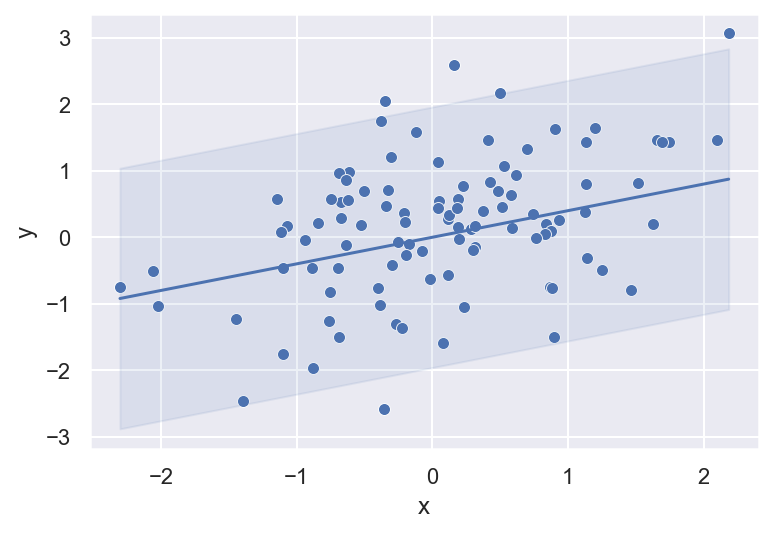

In [662]:
fig, ax = plt.subplots()
sns.scatterplot(x='x', y='y', data=data, ax=ax)
x_plot = np.linspace(np.min(data.x), np.max(data.x), 100)
mu = 0 + true_beta*x_plot
ax.plot(x_plot, mu)
ax.fill_between(x_plot, mu-1.96*true_sigma, mu+1.96*true_sigma, alpha=0.1, color='C0');

In [663]:
%%time
res = lmcavi(y=data.y.values, x=data.x.values, tau2=0.50**2)

CPU times: user 1.92 s, sys: 172 ms, total: 2.09 s
Wall time: 1.97 s


In [664]:
for k, v in res.items():
    print(k, v)

nu [5, 85.99691508047763, 44.9319400214422, 45.20028588366792, 45.19694962332356, 45.19699085879928, 45.196990349100325]
beta_mu 0.4822369035692976
beta_sd [1, 0.08425707755819214, 0.11656555680604262, 0.11621902748324146, 0.116223316818925, 0.11622326380073994, 0.11622326445608087]
ELBO [0, -289322.2509090142, 479.03846605499183, -333.3778750159492, -315.8128029358522, -316.0287743403664, -316.02610461210554]


In [665]:
beta_mu = res["beta_mu"]
beta_sd = res["beta_sd"][-1]
nu = res["nu"][-1]
a = (n + 1)/2

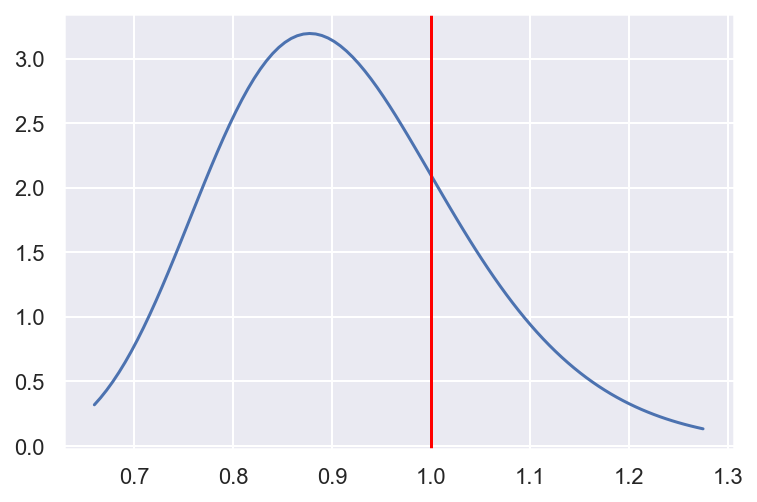

In [666]:
q_sigma2 = scipy.stats.invgamma(a=(n + 1)/2, scale=nu)

x_plot = np.linspace(q_sigma2.ppf(0.01), q_sigma2.ppf(0.99), 100)
fig, ax = plt.subplots()
ax.plot(x_plot, q_sigma2.pdf(x_plot))
ax.axvline(true_sigma**2, color='red');

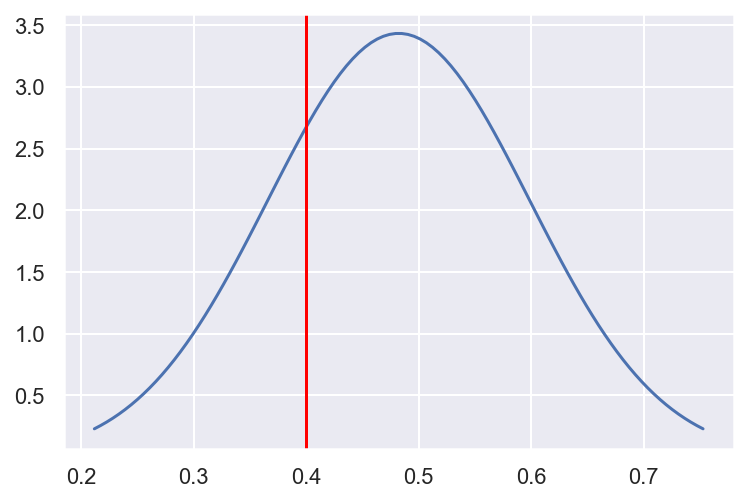

In [667]:
q_beta = scipy.stats.norm(loc=beta_mu, scale=beta_sd)

x_plot = np.linspace(q_beta.ppf(0.01), q_beta.ppf(0.99), 100)
fig, ax = plt.subplots()
ax.plot(x_plot, q_beta.pdf(x_plot))
ax.axvline(true_beta, color='red');

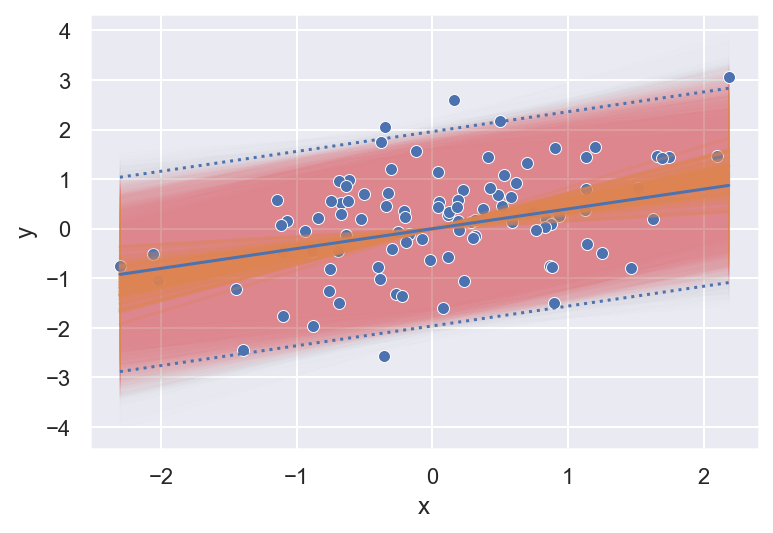

In [668]:
fig, ax = plt.subplots()

x_plot = np.linspace(np.min(data.x), np.max(data.x), 100)
for i in range(100):
    est_beta = q_beta.rvs()
    mu = 0 + est_beta*x_plot
    ax.plot(x_plot, mu, color='C1', alpha=0.3)
    est_sig = np.sqrt(q_sigma2.rvs())
    ax.fill_between(x_plot, mu-1.96*est_sig, mu+1.96*est_sig, alpha=0.002, color='C1')

sns.scatterplot(x='x', y='y', data=data, ax=ax, color='C0')
mu = 0 + true_beta*x_plot
ax.plot(x_plot, mu, color='C0')
ax.plot(x_plot, mu-1.96*true_sigma,  alpha=1, ls=':', color='C0')
ax.plot(x_plot, mu+1.96*true_sigma,  alpha=1, ls=':', color='C0');

## Naive implementation

In [720]:
def softplus(x):
    return np.log(1+np.exp(x))

def elbo(x, y, tau2=0.50**2):
    
    sum_x2 = np.sum(x**2)
    sum_yx = np.sum(x*y)
    n = len(y)
        
    beta_mu = sum_yx / (sum_x2 + 1/tau2)
    sigma2_shape = (n + 1)/2
    
    def E_q_beta(fn):
            return scipy.integrate.quad_vec(
                lambda beta: norm.pdf(loc=beta_mu, scale=beta_sd, x=beta) * fn(beta), 
                -np.inf, np.inf)[0]

    # Takes a function and computes its expectation with respect to q(\sigma^2)
    def E_q_sigma2(fn):
        return scipy.integrate.quad_vec(
            lambda sigma: invgamma.pdf(a=sigma2_shape, scale=sigma2_scale, x=sigma**2) * fn(sigma), 
            0, np.inf)[0]

    def log_p_y_given_q(beta, sigma2): 
        return invgamma.pdf(a=sigma2_shape, scale=sigma2_scale, x=sigma2) \
            * norm.pdf(loc=beta_mu, scale=beta_sd, x=beta) \
            * norm.logpdf(loc=beta*x, scale=sigma2**0.5, x=y).sum()
    
    def log_p_beta_given_q(beta, sigma2): 
        return invgamma.pdf(a=sigma2_shape, scale=sigma2_scale, x=sigma2) \
            * norm.pdf(loc=beta_mu, scale=beta_sd, x=beta) \
            * norm.logpdf(loc=0, scale=(sigma2+tau2)**0.5, x=y).sum()
    
    def opt(param):
        
        sigma2_scale, beta_sd = softplus(param)

        E_log_y = integrate.dblquad(log_p_y_given_q, 0, np.inf, 
                                    lambda x: -np.inf, lambda x: np.inf)[0]

        E_log_p_beta_cond_sigma2 = integrate.dblquad(log_p_beta_given_q, 
                                                     0, np.inf, 
                                                     lambda x: -np.inf, lambda x: np.inf)[0]

        E_log_p_sigma2 = E_q_sigma2(lambda sigma: np.log(1/sigma**2))

        E_log_q_beta = E_q_beta(lambda beta: norm.logpdf(loc=beta_mu, scale=beta_sd, x=beta))
        E_log_q_sigma2 = E_q_sigma2(lambda sigma: invgamma.logpdf(a=sigma2_shape, scale=sigma2_scale, x=sigma))


        elbo = E_log_y + E_log_p_beta_cond_sigma2 - E_log_q_beta + E_log_p_sigma2 - E_log_q_sigma2
        return - elbo
    return opt

## Variational inference with $\beta \neq 0$

$$ P(y \mid \mathbf{x}, \mathbf{w}) $$

In [731]:
from scipy.special import gammaln
import warnings

In [931]:
def vb_linear_fit(X, y, a0=1e-2, b0=1e-4, c0=1e-2, d0=1e-4, max_iter=500):
    """
    from https://github.com/DrugowitschLab/VBLinLogit/blob/master/src/vb_linear_fit.m
    """
    # [w, V, invV, logdetV, an, bn, E_a, L] = vb_linear_fit(X, y)
    #
    # estimates w sucht that y = Xw, using Bayesian regularisation.
    #
    # The function expects the arguments
    # - X: N x D matrix of training input samples, one per row
    # - y: N-element column vector of corresponding output samples
    # - a0, b0 (optional): scalar prior parameters of the noise precision
    # - c0, d0 (optional): scalar hyper-prior shrinkage parameters
    # If not given, the prior/hyper-prior parameters default to a0 = 1e-2,
    # b0 = 1e-4, c0 = 1e-2, and d0 = 1e-4, resulting in an uninformative prior.
    #
    # It returns
    # - w: posterior weight D-element mean vector
    # - V: posterior weight D x D covariance matrix
    # - invV, logdetV: inverse of V, and its log-determinant
    # - an, bn: scalar posterior parameter of noise precision
    # - E_a: scalar mean E(alpha) of shrinkage hyper-posterior
    # - L: variational bound, lower-bounding the log-model evidence p(y | X)
    #
    # The underlying generative model assumes
    #
    # p(y | x, w, tau) = N(y | w'x, tau^-1),
    #f
    # with x and y being the rows of the given X and y. w and tau are assigned
    # the conjugate normal inverse-gamma prior
    #
    # p(w, tau | alpha) = N(w | 0, (tau alpha)^-1 I) Gam(tau | a0, b0),
    #
    # with the hyper-prior
    #
    # p(alpha) = p(alpha | c0, d0).
    #
    # The returned posterior parameters (computed by variational Bayesian
    # inference) determine a posterior of the form
    #
    # N(w1 | w, tau^-1 V) Gam(tau | an, bn).
    #
    # Copyright (c) 2013-2019, Jan Drugowitsch
    # All rights reserved.
    # See the file LICENSE for licensing information.


    ## pre-process data
    N, D = X.shape
    X_corr = X.T @ X
    Xy_corr = X.T @ y
    an = a0 + N / 2    
    gammaln_an = gammaln(an)
    cn = c0 + D / 2    
    gammaln_cn = gammaln(cn)

    ## iterate to find hyperparameters
    L_last = -np.inf
    E_a = c0 / d0
    for i in range(max_iter):
        
        # covariance and weight of linear model
        invV = E_a * np.eye(D) + X_corr
        V = np.linalg.inv(invV)
        sign, logdet = np.linalg.slogdet(invV)
        logdetV = - logdet
        w = V@Xy_corr
        
        # parameters of noise model (an remains constant)
        sse = np.sum((X@w - y)** 2)
        bn = b0 + 0.5 * (sse + E_a * (w.T @ w))
        E_t = an / bn

        # hyperparameters of covariance prior (cn remains constant)
        dn = d0 + 0.5 * (E_t * (w.T @ w) + np.trace(V))
        E_a = cn / dn

        # variational bound, ignoring constant terms for now
        L = - 0.5 * (E_t * sse + np.sum(np.sum(X * (X @ V)))) + 0.5 * logdetV \
            - b0 * E_t + gammaln_an - an * np.log(bn) + an \
            + gammaln_cn - cn * np.log(dn)

        # variational bound must grow!
        if L_last > L:
            print(f'Last bound {L_last:.6f}, current bound {L:.6f}\n')
            raise Exception('Variational bound should not reduce')

        # stop if change in variation bound is < 0.001%
        if np.abs(L_last - L) < np.abs(0.00001 * L):
            break

        L_last = L    

    if i == max_iter-1:
        warnings.warn('Bayesian linear regression reached maximum number of iterations.')


    ## augment variational bound with constant terms
    L = L - 0.5 * (N * np.log(2 * np.pi) - D) - gammaln(a0) + a0 * np.log(b0) - gammaln(c0) + c0 * np.log(d0)
    return w, V, invV, logdetV, an, bn, E_a, L

# L, w, 1/(an/bn)

In [932]:
np.random.seed(123)

# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0 #1.0

# Generate and plot data
x = 10 * np.random.rand(100)
mu = alpha + beta * x
y = np.random.normal(mu, scale=sigma)

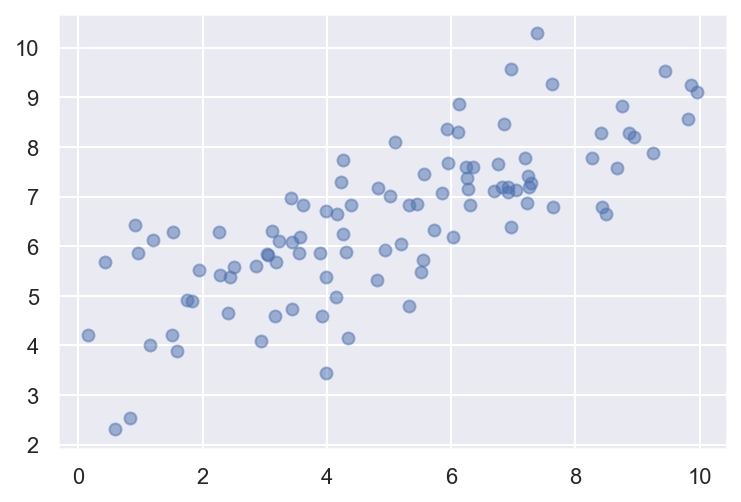

In [933]:
plt.scatter(x, y, alpha=0.5);

In [934]:
X = np.vstack((x, np.ones(x.shape))).T

In [935]:
X_corr = X.T@ X
X_corr

array([[3116.42697435,  501.42888005],
       [ 501.42888005,  100.        ]])

In [936]:
Xy_corr = X.T @ y
Xy_corr

array([3565.29919431,  654.21841722])

In [937]:
w, V, invV, logdetV, an, bn, E_a, L = vb_linear_fit(X=X, y=y)

In [948]:
est_alpha = w[1]
est_beta = w[0]
est_sigma = np.sqrt(bn/an)
print("lower bound", L)
print("est. alpha", est_alpha)
print("est. beta", est_beta)
print("est. sigma", est_sigma)

lower bound -157.86035119710778
est. alpha 4.146116413857438
est. beta 0.4769124179301443
est. sigma 0.9883248641712944


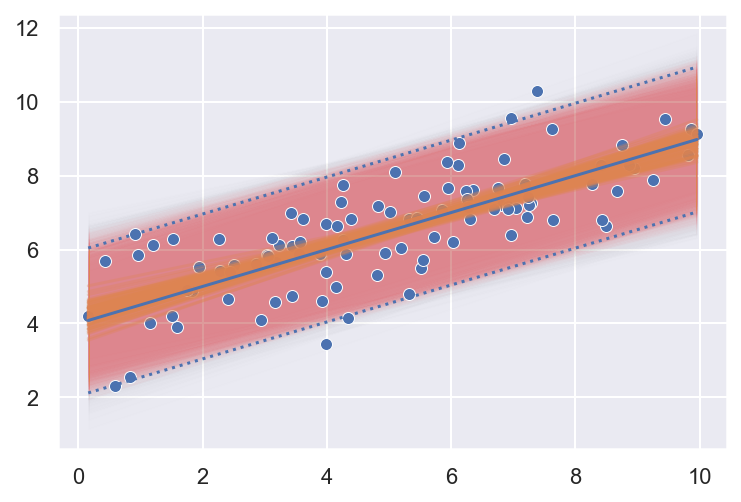

In [951]:
fig, ax = plt.subplots()

x_plot = np.linspace(np.min(x), np.max(x), 100)
for i in range(100):
    
    est_tau = scipy.stats.gamma(a=an, scale=1/bn).rvs()
    est_beta, est_alpha = scipy.stats.multivariate_normal(mean=w, cov=(1/est_tau)*V).rvs()
    est_sig = np.sqrt(1/est_tau)
    
    mu = est_alpha + est_beta*x_plot
    ax.plot(x_plot, mu, color='C1', alpha=0.3)
    ax.fill_between(x_plot, mu-1.96*est_sig, mu+1.96*est_sig, alpha=0.002, color='C1')

sns.scatterplot(x=x, y=y, ax=ax, color='C0')
mu = alpha + beta*x_plot
ax.plot(x_plot, mu, color='C0')
ax.plot(x_plot, mu-1.96*true_sigma,  alpha=1, ls=':', color='C0')
ax.plot(x_plot, mu+1.96*true_sigma,  alpha=1, ls=':', color='C0');

# Playing with integrals

In [673]:
from scipy import integrate
from scipy.stats import invgamma, norm

In [705]:
def f(y, x): 
    return x*y**2
integrate.dblquad(f, 0, 2, lambda x: 0, lambda x: 1)[0]

0.6666666666666667

In [677]:
x = data.x.values
y = data.y.values
n = len(y)

beta_mu = res["beta_mu"]
beta_sd = res["beta_sd"][-1]
sigma2_scale = res["nu"][-1]
sigma2_shape = (n + 1)/2

In [704]:
%%time
def f(beta, sigma2): 
    return invgamma.pdf(a=sigma2_shape, scale=sigma2_scale, x=sigma2) \
    * norm.pdf(loc=beta_mu, scale=beta_sd, x=beta) \
    * norm.logpdf(loc=beta*x, scale=sigma2**0.5, x=y).sum()
integrate.dblquad(f, 0, np.inf, lambda x: -np.inf, lambda x: np.inf)

CPU times: user 22.7 s, sys: 200 ms, total: 22.9 s
Wall time: 22.9 s


(-1.3679353318136167, 3.274413462381601e-08)

In [680]:
sum_y2 = np.sum(y**2)
sum_x2 = np.sum(x**2)
sum_yx = np.sum(x*y)

def E_q_sigma2(fn):
    return scipy.integrate.quad_vec(
        lambda sigma: invgamma.pdf(a=sigma2_shape, scale=sigma2_scale, x=sigma**2) \
            * fn(sigma), 
        0, np.inf)[0]

E_log_y_b = sum_y2 - 2*sum_yx*beta_mu + (beta_sd**2 + beta_mu**2)*sum_x2
E_log_y_sigma2 = E_q_sigma2(lambda sigma: np.log(sigma**2) * 1/sigma**2)
n/4 * np.log(2*np.pi) * E_log_y_b * E_log_y_sigma2

-319.0960337665618

In [723]:
%%time

Nfeval = 1

def callbackF(Xi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}'.format(Nfeval, Xi[0], Xi[1]))
    Nfeval += 1

print('{0:4s}   {1:9s}   {2:9s}'.format('Iter', ' X1', ' X2'))
res = scipy.optimize.minimize(elbo(x=x, y=y), x0=(0, 0), callback=callbackF)
print(res)

Iter    X1          X2      
   1   -21.195463    0.785131
   2   -21.216181    1.372256
   3   -21.331518    4.640880
   4   -21.418063    7.093525
   5   -22.263827    31.062165
   6   -22.514509    38.166385
   7   -23.610423    69.224172
   8   -24.957461    107.398739
   9   -27.400344    176.629138
  10   -31.201522    284.353088


/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1877: RuntimeWarning: divide by zero encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
<ipython-input-720-c4cfc19c1b75>:2: RuntimeWarning: overflow encountered in exp
  return np.log(1+np.exp(x))
<ipython-input-720-c4cfc19c1b75>:15: RuntimeWarning: invalid value encountered in double_scalars
  lambda beta: norm.pdf(loc=beta_mu, scale=beta_sd, x=beta) * fn(beta),
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/integrate/_quad_vec.py:503: RuntimeWarning: invalid value encountered in double_scalars
  s_k_dabs += v[i] * abs(fv[i] - y0)
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/integrate/_quad_vec.py:506: RuntimeWarning: invalid value encountered in double_scalars
  err = float(norm_func((s_k - s_g) * h))
/Users/aureliennioche/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/stats/_dist

  11   -6394.318780    180612.718614
      fun: nan
 hess_inv: array([[   63.4610399 , -1766.76574625],
       [-1766.76574625, 50069.48110043]])
      jac: array([nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 375
      nit: 11
     njev: 125
   status: 2
  success: False
        x: array([ -6394.31877979, 180612.71861414])
CPU times: user 5h 3min 51s, sys: 3min 8s, total: 5h 7min
Wall time: 5h 7min 33s


# Play with expectations

In [630]:
scipy.stats.norm(loc=10, scale=20).logpdf(10)

-3.9146708067586635

In [ ]:
nr_samples = 5000
n = 500
nu = 2
a = (n + 1)/2
q_sigma2 = scipy.stats.invgamma(a=a, scale=nu)
sigma2 = q_sigma2.rvs(size=nr_samples) 
E_log_q_sigma2 = q_sigma2.logpdf(sigma2).mean()
print(E_log_q_sigma2)

In [ ]:
np.log(nu / (a-1))

In [ ]:
shape=2
scale=3

q_sigma2 = scipy.stats.gamma(a=shape, scale=scale)
sigma2 = q_sigma2.rvs(size=1000000) 
E_log_q_sigma2 = q_sigma2.logpdf(sigma2).mean()
print(E_log_q_sigma2)

In [ ]:
np.mean(sigma2)

In [ ]:
shape*scale

In [ ]:
np.mean(np.log(sigma2))

In [ ]:
# https://stats.stackexchange.com/questions/370880/what-is-the-expected-value-of-the-logarithm-of-gamma-distribution/371031
np.log(scale) + scipy.special.psi(shape)

In [468]:
shape=13
scale=5

q_sigma2 = scipy.stats.invgamma(a=shape, scale=scale)
sigma2 = q_sigma2.rvs(size=1000000) 
E_log_q_sigma2 = q_sigma2.logpdf(sigma2).mean()
print(E_log_q_sigma2)

0.7670519493615556


In [433]:
np.mean(sigma2)

0.41657347000189876

In [434]:
scale/(shape-1)

0.4166666666666667

In [435]:
np.mean(np.log(sigma2))

-0.9166990354757938

In [436]:
# https://stats.stackexchange.com/questions/135119/log-inverse-gamma-distribution
np.log(scale) - scipy.special.psi(shape)

-0.916557100875045

# References

* https://en.wikipedia.org/wiki/Variational_Bayesian_methods
* https://fabiandablander.com/r/Variational-Inference.html#fnref:1
* https://bjlkeng.github.io/posts/variational-bayes-and-the-mean-field-approximation/
* https://arxiv.org/pdf/1310.5438.pdf
* https://leimao.github.io/article/Introduction-to-Variational-Inference/